# Example Jupyter notebook to work with the data

# Read in and plot the Apollo 12 Grade B 

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from obspy import Trace
import os
from pathlib import Path


Let's pick the first seismic event in the catalog and let's take a look at the absolute time data. The way we show it here is by using pandas `.iloc` and datetime `.strptime`. We are going to keep the format shown in the absolute time header, which is `'%Y-%m-%dT%H:%M:%S.%f'`

## Read the CSV file

We will now find the csv data file corresponding to that time and plot it!

In [2]:
from pathlib import Path

def get_csv_files(folder_path):
    # Using pathlib for more flexible file management
    folder_path = Path(folder_path)
    csv_files = list(folder_path.glob('*.csv'))
    return csv_files
    
csv_files=get_csv_files('C:/Users/mgil/Desktop/Nasa_space_apps/space_apps_2024_seismic_detection/data/lunar/test/data/S12_GradeB')

## Repeating the loop for calculating success rate

In [3]:
csv_file=csv_files[44]
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1973-08-08T00:00:18.557861,0.000000,-5.324975e-15
1,1973-08-08T00:00:18.708804,0.150943,-6.692782e-15
2,1973-08-08T00:00:18.859748,0.301887,-7.302275e-15
3,1973-08-08T00:00:19.010691,0.452830,-7.052499e-15
4,1973-08-08T00:00:19.161635,0.603774,-6.216345e-15
...,...,...,...
572277,1973-08-08T23:59:59.991823,86381.433962,1.665582e-16
572278,1973-08-09T00:00:00.142767,86381.584906,-9.882056e-16
572279,1973-08-09T00:00:00.293710,86381.735849,-1.448389e-15
572280,1973-08-09T00:00:00.444653,86381.886792,-1.771166e-15


Text(0.5, 1.0, 'C:\\Users\\mgil\\Desktop\\Nasa_space_apps\\space_apps_2024_seismic_detection\\data\\lunar\\test\\data\\S12_GradeB\\xa.s12.00.mhz.1973-08-08HR00_evid00437.csv')

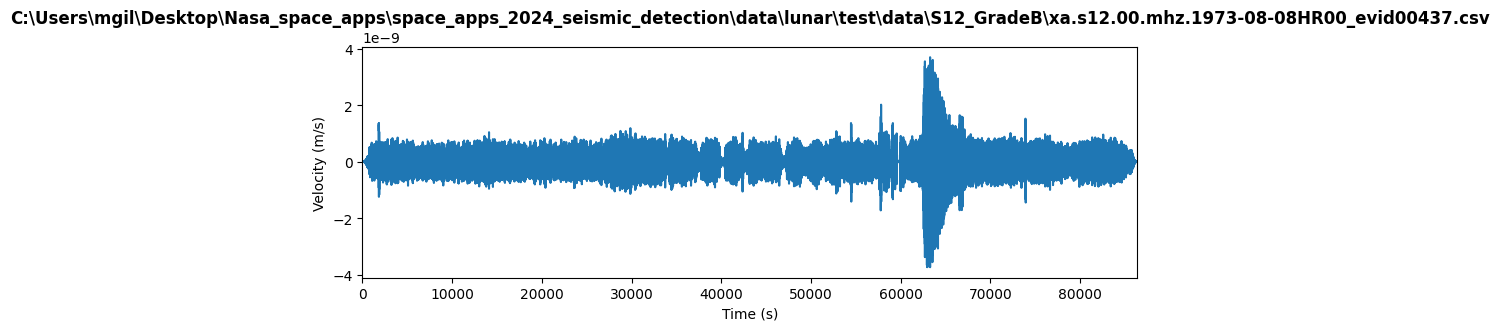

In [4]:
test_filename = csv_file

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

## See the signal in the frequency spectrum and finding at which frequency corresponds the maximum magnitude

Number of samples: 572282
FFT computation completed.
Frequency bins computed.
Magnitude spectrum calculated and normalized.


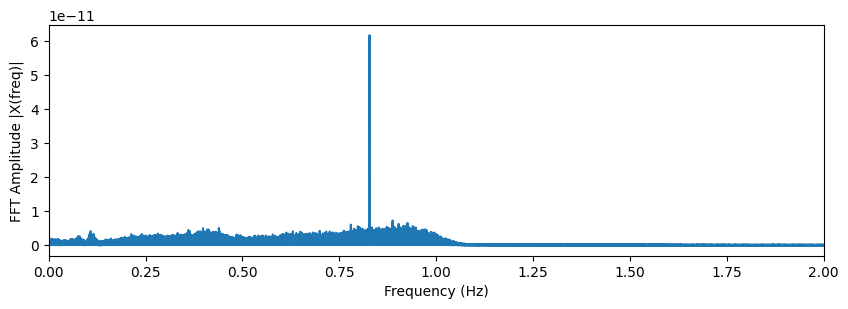

Maximum Magnitude: 6.171969247721405e-11
Maximum Frequency: 0.83 Hz
Frequency Window: [0.68 Hz, 0.98 Hz]


In [5]:
def apply_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a band-pass filter to the data.

    Parameters:
    - data: NumPy array of seismic data.
    - lowcut: Low cutoff frequency in Hz.
    - highcut: High cutoff frequency in Hz.
    - fs: Sampling rate in Hz.
    - order: Order of the filter.

    Returns:
    - filtered_data: NumPy array of filtered data.
    """
    from scipy.signal import butter, filtfilt
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data



def compute_fft(signal, sampling_rate):
    """
    Compute the Fast Fourier Transform (FFT) of a signal and return the frequency and magnitude spectrum.

    Parameters:
    ----------
    signal : array_like
        The input time-domain signal (1D NumPy array).
    sampling_rate : float
        The sampling rate of the signal in Hertz (Hz).

    Returns:
    -------
    freqs : numpy.ndarray
        Array of frequency bins corresponding to the FFT components.
    magnitude : numpy.ndarray
        Magnitude spectrum of the FFT.
    """
    # Number of samples in the signal
    N = len(signal)
    print(f"Number of samples: {N}")

    # Compute the FFT using NumPy's FFT function
    fft_vals = np.fft.fft(signal)
    print("FFT computation completed.")

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, d=1/sampling_rate)
    print("Frequency bins computed.")

    # Only take the positive half of the spectrum (real signals are symmetric)
    positive_freqs = freqs[:N // 2]
    positive_fft = fft_vals[:N // 2]

    # Compute the magnitude spectrum and normalize
    magnitude = (2.0 / N) * np.abs(positive_fft)
    print("Magnitude spectrum calculated and normalized.")

    return positive_freqs, magnitude

N=len(csv_data);
fa=1/((csv_times[2]-csv_times[1]));
freqs,magnitude=compute_fft(csv_data,fa)
    
# Plot FFT
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(freqs, magnitude)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT Amplitude |X(freq)|')
ax.set_xlim(0, 2)  # Adjust as needed

plt.show()
import numpy as np

# Step 1: Find the index of the maximum magnitude
max_magnitude = max(magnitude)
max_index = np.argmax(magnitude)

# Step 2: Get the frequency corresponding to the max magnitude
max_frequency = freqs[max_index]

# Step 3: Define the window around the max frequency (e.g., ±0.1 Hz)
freq_window_lower = max_frequency - 0.15
freq_window_upper = max_frequency + 0.15

print(f"Maximum Magnitude: {max_magnitude}")
print(f"Maximum Frequency: {max_frequency:.2f} Hz")
print(f"Frequency Window: [{freq_window_lower:.2f} Hz, {freq_window_upper:.2f} Hz]")




## Filtering the signal in the frequency using a band pass filter

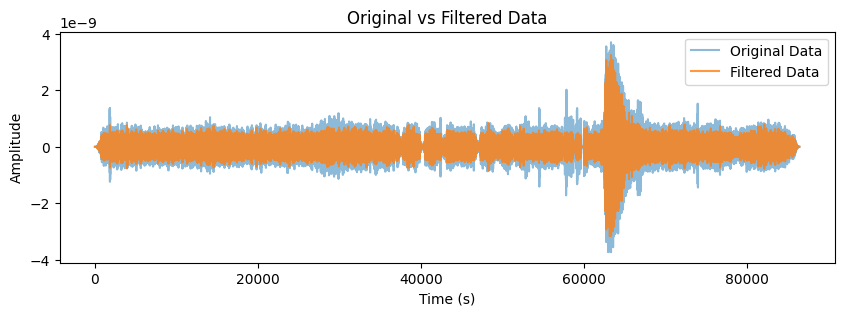

Number of samples: 572282
FFT computation completed.
Frequency bins computed.
Magnitude spectrum calculated and normalized.


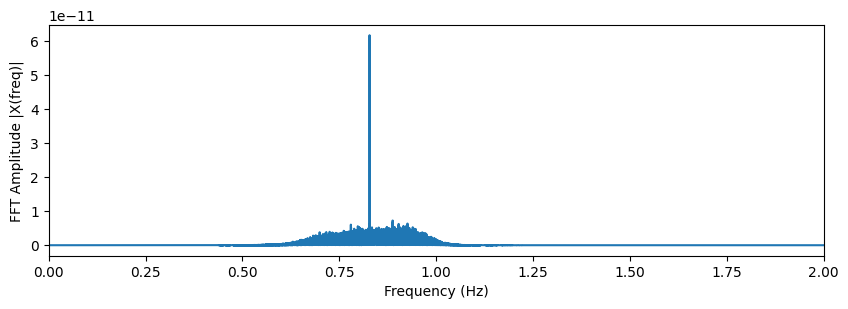

In [6]:
import pandas as pd
from obspy import Trace



# Step 2: Create Trace Object
delta_t = csv_times[1] - csv_times[0]
fa = 1.0 / delta_t
trace = Trace(data=csv_data)
trace.stats.sampling_rate = fa
        
# Apply the bandpass filter for each pair of a[i] and b[i]
trace_filtered = trace.filter('bandpass', freqmin=freq_window_lower, freqmax=freq_window_upper)

# Step 4: Access Filtered Data and Times
filtered_data = trace_filtered.data
filtered_times = csv_times

# Step 5: (Optional) Save to CSV
filtered_df = pd.DataFrame({'time': filtered_times, 'filtered_amplitude': filtered_data})
filtered_df.to_csv('filtered_seismic_data.csv', index=False)



# Step 6: (Optional) Plot the Data
import matplotlib.pyplot as plt
# Plot original data and filtered data
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(csv_times, csv_data, label='Original Data', alpha=0.5)
ax.plot(filtered_times, filtered_data, label='Filtered Data', alpha=0.8)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Original vs Filtered Data')
ax.legend()
plt.show()

freqs,magnitude=compute_fft(filtered_data,fa)
    
# Plot FFT
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(freqs, magnitude)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT Amplitude |X(freq)|')
ax.set_xlim(0, 2)  # Adjust as needed

plt.show()



## The filtered signal in the time spectrum

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


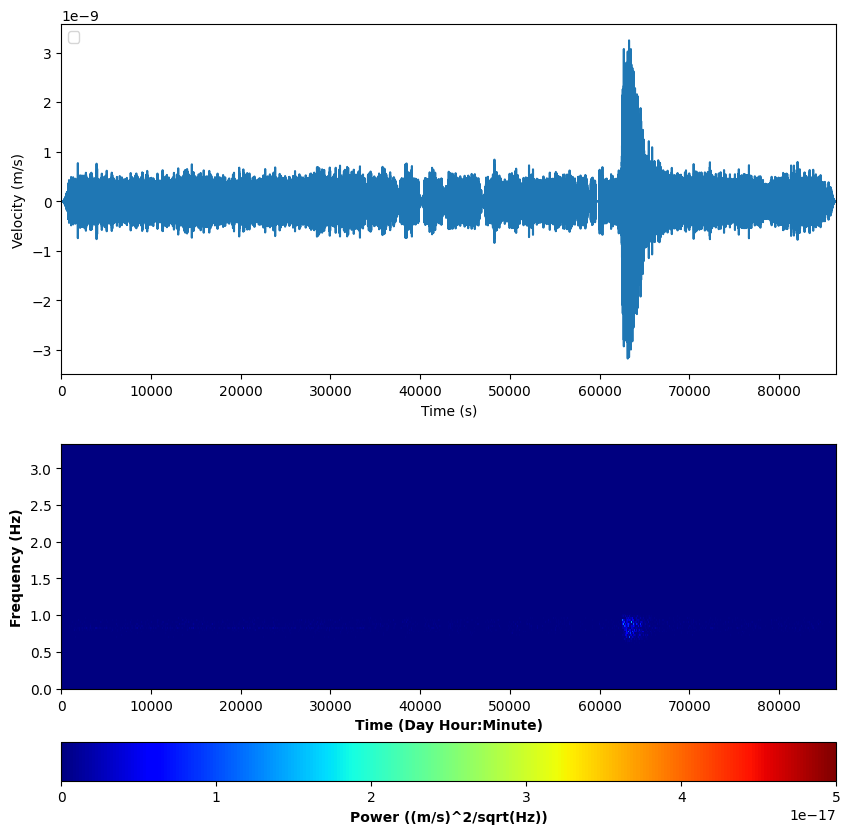

In [7]:
from scipy import signal
from matplotlib import cm
f, t, sxx = signal.spectrogram(filtered_data, fa)

# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(csv_times,filtered_data)
# Mark detection
ax.legend(loc='upper left')
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(csv_times),max(csv_times)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

## Normalização do sinal filtrado

Potencia do sinal 1.656282030237762e-07
Média do sinal normalizado ao quadrado é : 1.7473902726278215e-06


Text(0.5, 1.0, 'C:\\Users\\mgil\\Desktop\\Nasa_space_apps\\space_apps_2024_seismic_detection\\data\\lunar\\test\\data\\S12_GradeB\\xa.s12.00.mhz.1973-08-08HR00_evid00437.csv')

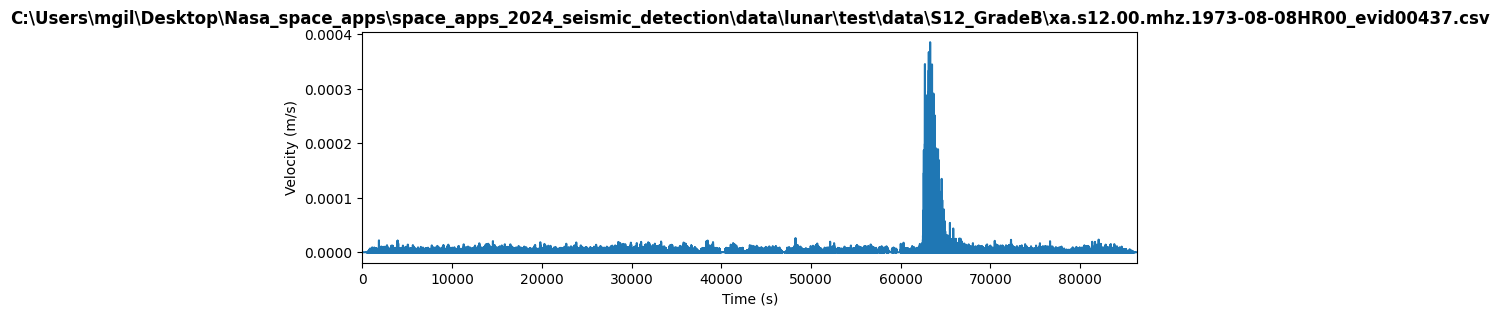

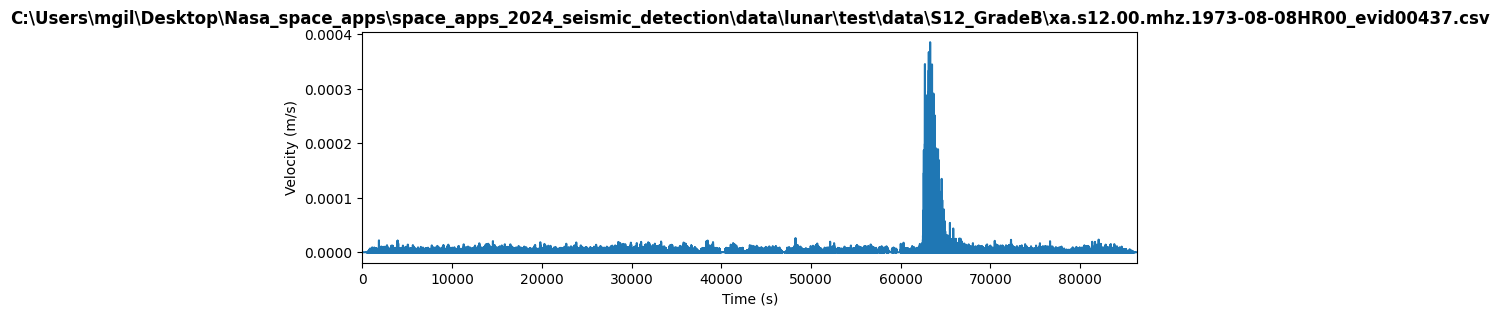

In [8]:
# Calculate the L2 norm (Euclidean norm) of the signal
Potencia = np.sqrt(np.sum(filtered_data**2))
filtered_data_normalizado=filtered_data/Potencia
print('Potencia do sinal',Potencia)
filtered_data_normalizado_sq=filtered_data_normalizado**2
# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(filtered_times,filtered_data_normalizado_sq)

# Make the plot pretty
ax.set_xlim([min(filtered_times),max(filtered_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{csv_file}', fontweight='bold')

Media_do_sinal=sum(filtered_data_normalizado_sq)/len(filtered_data_normalizado_sq)
print('Média do sinal normalizado ao quadrado é :',Media_do_sinal)

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(filtered_times,filtered_data_normalizado_sq)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold') 

## Algorithm for finding optimal treshold 

media é: 3.375636372045147e-06
Contagem em cada faixa: [53817, 2475, 1169, 637, 409, 289, 181, 123, 83, 62, 35, 27, 20, 16, 18, 6, 5, 3, 1, 2]
Contagem em cada faixa: [53817, 2475, 1169, 637, 409, 289, 181, 123, 83, 62, 35, 27, 20, 16, 18, 6, 5, 3, 1, 2]
[[62839.3962264151, 18], [63492.52830188679, 23], [63540.52830188679, 18]]
Média das posições: 63291


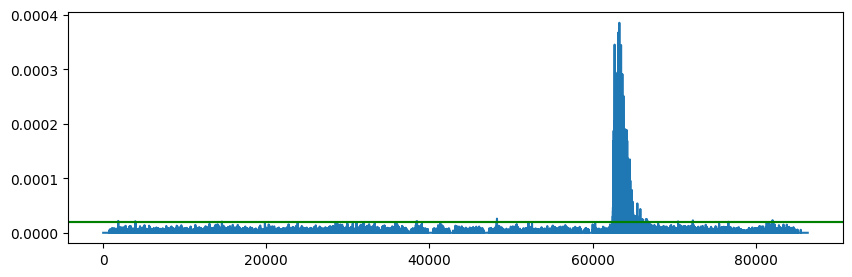

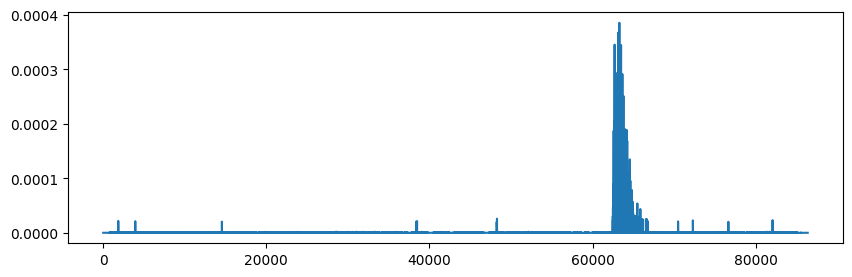

In [9]:
csv_data_normalizado_ao_quadrado=filtered_data_normalizado_sq.copy()

mediana= np.median (csv_data_normalizado_ao_quadrado)

media = 0
counter=0
mediana= np.median (csv_data_normalizado_ao_quadrado)
for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
         if csv_data_normalizado_ao_quadrado[i] > mediana:
            media = media + csv_data_normalizado_ao_quadrado[i]
            counter= counter + 1
#print('V max é:', v_max)
print('media é:', media/counter)
for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
         if csv_data_normalizado_ao_quadrado[i] < media/counter:
            csv_data_normalizado_ao_quadrado[i]=0

fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data_normalizado_ao_quadrado)

# Definindo o número de intervalos
num_intervals = 20

# Encontrar o valor máximo
v_max = 0
for i in range(1, len(csv_data_normalizado_ao_quadrado)):
    if csv_data_normalizado_ao_quadrado[i] > v_max:
        v_max = csv_data_normalizado_ao_quadrado[i]

# Calcular o espaço de cada faixa
space = (v_max - mediana) / num_intervals

# Inicializar a lista com zeros para os intervalos
place = [0] * num_intervals

# Loop sobre os dados normalizados ao quadrado para contar em cada intervalo
for i in range(1, len(csv_data_normalizado_ao_quadrado)):
    # Verifica em qual faixa a amostra se encontra
    for j in range(num_intervals):
        lower_bound = mediana + j * space
        upper_bound = mediana + (j + 1) * space
        if lower_bound < csv_data_normalizado_ao_quadrado[i] <= upper_bound:
            place[j] += 1
            break  # Para evitar contar duas vezes

# Exibir os resultados
print("Contagem em cada faixa:", place)
arrival_line = ax.axhline(y=mediana + space, c='green', label='Rel. Arrival')

max_valor = max(place)  # Encontrar o maior valor
max_indice = place.index(max_valor)  # Encontrar o índice do maior valor
media_media = mediana + (1 + max_indice) * space
# Exibir os resultados
print("Contagem em cada faixa:", place)
arrival_line = ax.axhline(y=mediana + space, c='green', label='Rel. Arrival')


max_valor = max(place)  # Encontrar o maior valor
max_indice = place.index(max_valor)  # Encontrar o índice do maior valor
media_media = mediana + (1+ max_indice)*space

signal_fn = [] 
for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
         if csv_data_normalizado_ao_quadrado[i] < media_media:
            csv_data_normalizado_ao_quadrado[i]*=0.1
signal_fn = csv_data_normalizado_ao_quadrado.copy()
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data_normalizado_ao_quadrado)

position = 0
times = 0
contador = 0
trigger = 0
array = []
k = 64

# Loop until the array is not empty
while len(array) == 0:
    for i in range(1, len(csv_data_normalizado_ao_quadrado)):        
        if csv_data_normalizado_ao_quadrado[i] > media_media:
            contador += 1
            trigger = 1
            if contador > k:
                position = csv_times[i - k]  # Get the position at i - k

        if csv_data_normalizado_ao_quadrado[i] < media_media:
            if trigger == 1 and contador > k:
                times = contador
                array.append([position, times])  # Append position and times to array
            contador = 0
            trigger = 0

    # If array is still empty after the loop, reduce k by half
    if len(array) == 0:
        k = k // 2  # Divide k by 2

# Output the result
print(array)

# Calculate the average of the positions
positions = [item[0] for item in array]  # Extracting positions
media_positions = round(np.mean(positions))  # Calculate the mean of positions

# Print the average positions
print(f'Média das posições: {media_positions}')


## Filtered signal after data analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


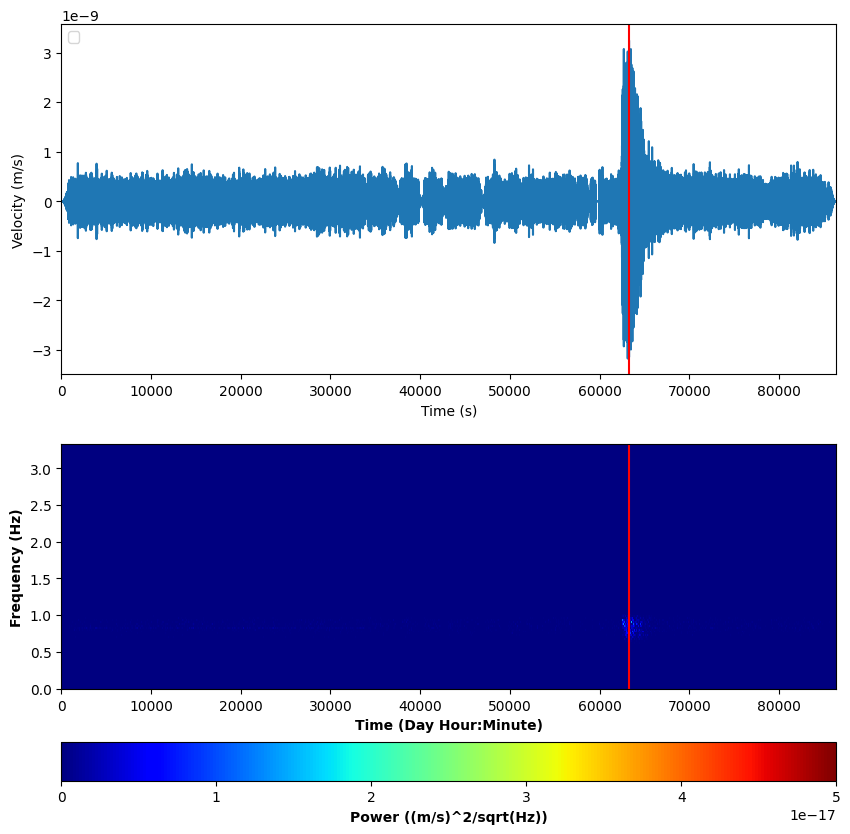

In [10]:
# Plot the time series and spectrogram
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(2, 1, 1)
# Plot trace
ax.plot(csv_times,filtered_data)
# Mark detection
ax.legend(loc='upper left')
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.axvline(x=media_positions, c='red')
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax2 = plt.subplot(2, 1, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
ax2.set_xlim([min(csv_times),max(csv_times)])
ax2.set_xlabel(f'Time (Day Hour:Minute)', fontweight='bold')
ax2.set_ylabel('Frequency (Hz)', fontweight='bold')
ax2.axvline(x=media_positions, c='red')
cbar = plt.colorbar(vals, orientation='horizontal')
cbar.set_label('Power ((m/s)^2/sqrt(Hz))', fontweight='bold')

# Sample short-term average / long-term average (STA/LTA) detection algorithm

A STA/LTA algorithm moves two time windows of two lengths (one short, one long) across the seismic data. The algorithm calculates the average amplitude in both windows, and calculates the ratio between them. If the data contains an earthquake, then the short-term window containing the earthquake will be much larger than the long-term window -- resulting in a detection. 

Text(0, 0.5, 'Characteristic function')

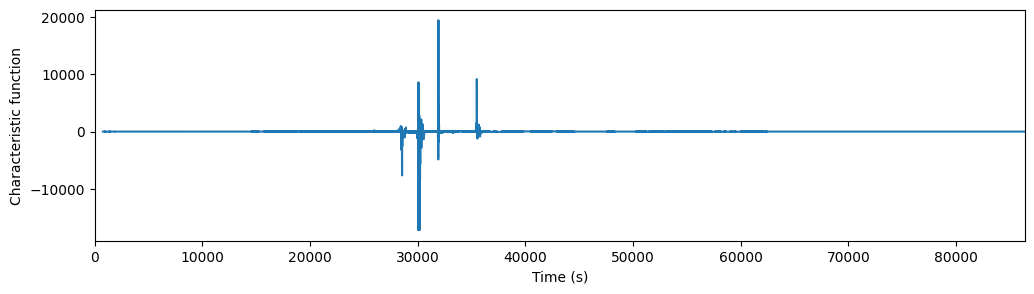

In [11]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset


# How long should the short-term and long-term window be, in seconds?
sta_len = 1
lta_len = 6

# Run Obspy's STA/LTA to obtain a characteristic function
# This function basically calculates the ratio of amplitude between the short-term 
# and long-term windows, moving consecutively in time across the data
cft = classic_sta_lta(signal_fn, int(sta_len * fa), int(lta_len * fa))

# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(csv_times,cft)
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')

Next, we define the values of the characteristic function (i.e. amplitude ratio between short-term and long-term windows) where we flag a seismic detection. These values are called triggers. There are two types of triggers -- "on" and "off", defined as follows:

1. "on" : If the characteristic function is above this value, then a seismic event begins. 
2. "off" : If the characteristic function falls below this value (after an "on" trigger), than a seismic event ends. 

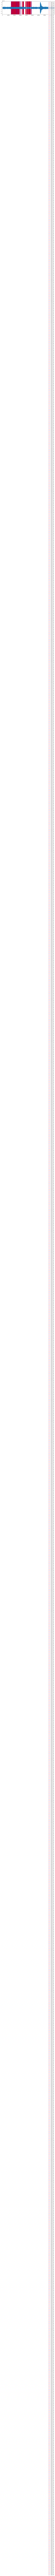

In [12]:
# Play around with the on and off triggers, based on values in the characteristic function
Mean_cft=sum(cft)/len(cft)
thr_on = 8
thr_off = 2
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = csv_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = csv_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(csv_times,filtered_data)
ax.set_xlim([min(csv_times),max(csv_times)])
ax.legend()

**Note**: You do not have to worry about marking the end of the seismic trace (as you can see, even for us it's not very accurate!). For this challenge, all we care about is the start of the seismic waveform.

## Sample detection export into a catalog! 
There are many ways to do this, but we'll show a way to do it using pandas. 

In [13]:
csv_times_dt = []
for absval_str in data_cat['time_abs(%Y-%m-%dT%H:%M:%S.%f)'].values:
    csv_times_dt.append(datetime.strptime(absval_str,'%Y-%m-%dT%H:%M:%S.%f'))
    

# File name and start time of trace
fname = csv_file
starttime = csv_times_dt[1]

# Iterate through detection times and compile them
detection_times = []
fnames = []
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    on_time = starttime + timedelta(seconds = csv_times[triggers[0]])
    on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')
    detection_times.append(on_time_str)
    fnames.append(fname)
    
# Compile dataframe of detections
detect_df = pd.DataFrame(data = {'filename':fnames, 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':csv_times[triggers[0]]})
detect_df.head()

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,C:\Users\mgil\Desktop\Nasa_space_apps\space_ap...,1973-08-08T04:03:00.067295,48238.188679
1,C:\Users\mgil\Desktop\Nasa_space_apps\space_ap...,1973-08-08T04:03:13.048427,48238.188679
2,C:\Users\mgil\Desktop\Nasa_space_apps\space_ap...,1973-08-08T04:03:26.180502,48238.188679
3,C:\Users\mgil\Desktop\Nasa_space_apps\space_ap...,1973-08-08T04:04:17.199370,48238.188679
4,C:\Users\mgil\Desktop\Nasa_space_apps\space_ap...,1973-08-08T04:04:42.255974,48238.188679


This can then be exported to a csv using:

`detect_df.to_csv('output/path/catalog.csv', index=False)`

# Download additional data from Earth-based stations

You may find that you need to download additional data from Earth stations to supplement your models and algorithms. We recommend that you download any events from IRIS (Incorporated Research Institutations for Seismology).

https://www.iris.edu/hq/

**Note**: The organization has been recently renamed to SAGE (Seismological Facility for the Advancement of Geoscience), but all the previous links should still work. 

They maintain and curate data from seismic stations all around the world. There are many different ways to get data from them, but I recommend using the utility *PyWeed*:

https://ds.iris.edu/ds/nodes/dmc/software/downloads/pyweed/

We can use the utility to select seismic stations and the earthquake data (or **events**) recorded at those stations.

<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/station_data_location.png" alt="Drawing" style="width: 1200px;">

For this test case, let's download all of the earthquakes magnitude 3 and above that are within 1 degree distance (approximately 110 km) from a site called PFO (Pinon Flat Observatory) in California. **Location** is a number designating the instrument at a particular site (sites may have multiple instruments), and **channel** is an IRIS code that specifies instrument information. 

In short, the first latter refers to the samplerate of the instrument (how many data points it records per second), the second to the type of instrument (certain types of seismometers are better at recording nearby earthquakes while others are more suited for distant earthquakes), and the last to the directional component being recored (most seismometers will record motion across two horizontal directions and the vertical). We will pick the channel HHZ, which refers to a (H) high-samplerate (100 samples per second) (H) strong-motion accelerometer (best resolution for nearby strong earthquakes) recording in the (Z) vertical direction. Once you've selected all the earthquakes, you can download the traces. 

An earthquake is composed of the following types of waves (in order): pressure (P-wave), shear (S-wave), and surface (Rayleigh and Love). For our challenge, we are only interested in identifying the start of the earthquake. The IRIS dataset contains P-wave arrivals (onset of the P-wave at the seismometer) for each earthquake. In order to get noise prior to the earthquake arrival, we pick our data traces to span 101 seconds before to 60 seconds past the P-wave arrival:


<img src="https://raw.githubusercontent.com/civilinifr/fc_deeplearning/master/eq_detector_images/selected_seismograms.png" alt="Drawing" style="width: 1200px;">


As you can see from the output list, some of the earthquakes don't record any earthquake data (3.4 Ml 2005-08-31) and others have an incorrect P-wave arrival time (4.0 Ml 2005-08-31). Make sure to go through the earthquakes and remove those types of events from the waveform preview prior to download. For output file type, choose miniseed to match the planetary data (SAC is probably fine too, but the file sizes tend to be a bit bigger). 

## Thank you very much for being a part of this challenge! Good luck!!!